# Prepare Import and stuffs

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
from keras.optimizers import Adam, RMSprop

from shutil import copyfile
import os
from keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt

import keras
from keras import layers
import os
import tensorflow as tf
from keras.layers import BatchNormalization
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tqdm import tqdm_notebook
import os 
from keras.preprocessing import image
from tqdm import tqdm_notebook



Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!unzip '/content/drive/My Drive/flagsDataset/Zips/data.zip' > /dev/null

In [0]:
!rm -rf 'Resized'

# Create Model

In [0]:
latent_dim = 100
height = 64
width = 64
channels = 3
import keras
from keras import layers
import os
import tensorflow as tf
from keras.layers import BatchNormalization

In [0]:
generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 32 * 32)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((32, 32, 128))(x)

x = layers.Conv2DTranspose(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 131072)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 256)       1048

In [0]:


discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 128)       0   

In [0]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [0]:
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         18421507  
_________________________________________________________________
model_2 (Model)              (None, 1)                 795009    
Total params: 19,216,516
Trainable params: 18,421,507
Non-trainable params: 795,009
_________________________________________________________________


# Train Model

In [0]:
from skimage.transform import rescale
list_file = os.listdir('Resized')

# # random.shuffle(list_file)
data_train_gan = np.array([resize(imread(os.path.join('Resized',file_name)), (64, 64)) for file_name in list_file])


In [0]:
data_train_gan.shape

(6611, 64, 64, 3)

In [0]:
x_train = data_train_gan
iterations = 10000
batch_size = 36
save_dir = '.'


start = 0
import matplotlib.pyplot as plt

In [0]:
x_train.shape
# (36, 64, 64, 3)
# (36, 64, 3)

(6611, 64, 64, 3)

In [0]:
!mkdir Generated

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6879704
advesarial loss: 0.65676284


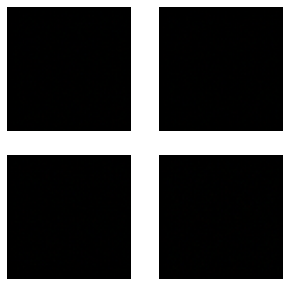

discriminator loss: 0.6879704
advesarial loss: 0.65676284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.39588192
advesarial loss: 3.4164739


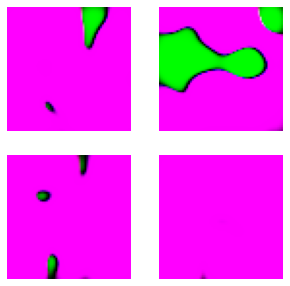

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6558721
advesarial loss: 1.0417563


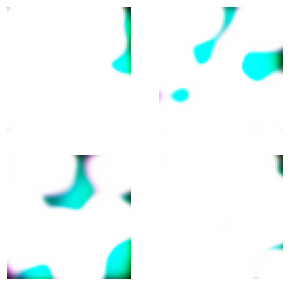

discriminator loss: 0.7445128
advesarial loss: 0.5472402


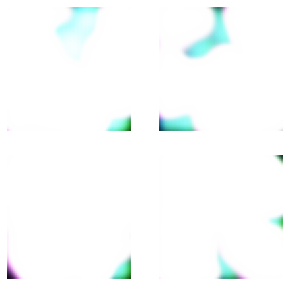

discriminator loss: 0.3529554
advesarial loss: 1.8746145


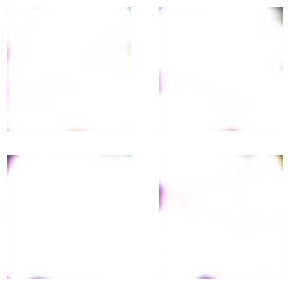

discriminator loss: 0.3522907
advesarial loss: 1.9443097


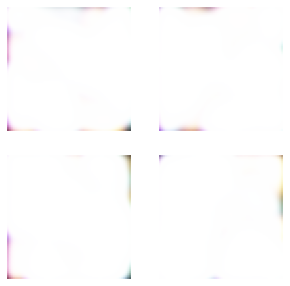

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 2.5180578
advesarial loss: 9.476933


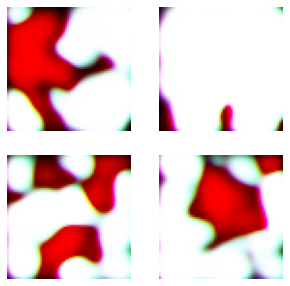

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 2.0701394
advesarial loss: 32.17007


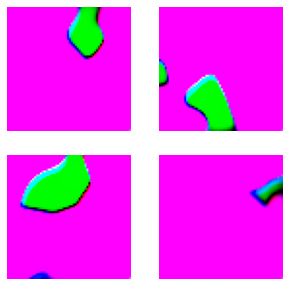

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.12602705
advesarial loss: 12.870037


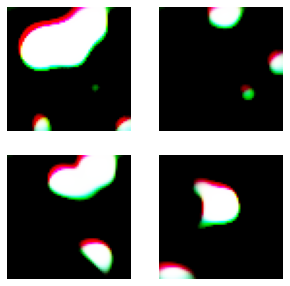

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6819431
advesarial loss: 1.6865137


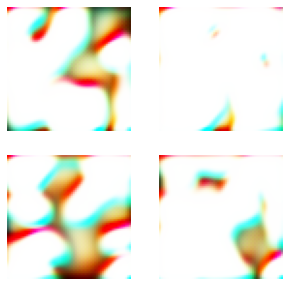

discriminator loss: 0.7755778
advesarial loss: 1.9159241


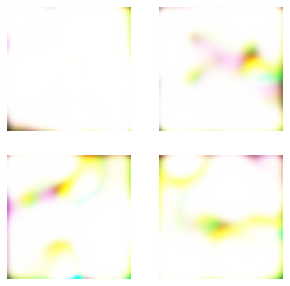

discriminator loss: 0.7755778
advesarial loss: 1.9159241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.4879278
advesarial loss: 0.57340395


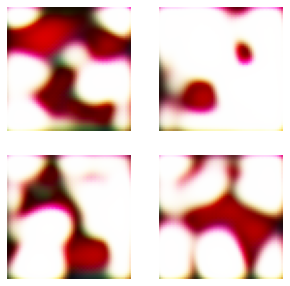

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6408852
advesarial loss: 1.0766476


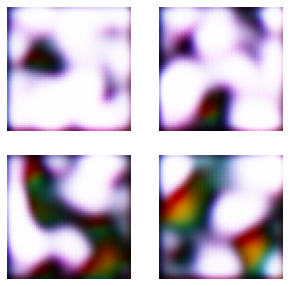

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.57323945
advesarial loss: 0.7657695


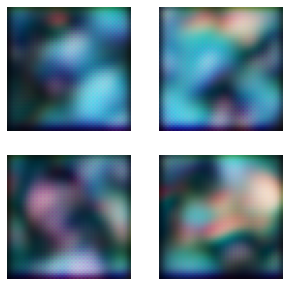

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.8043459
advesarial loss: 1.7663738


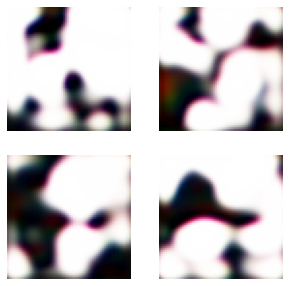

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.70254344
advesarial loss: 0.97241646


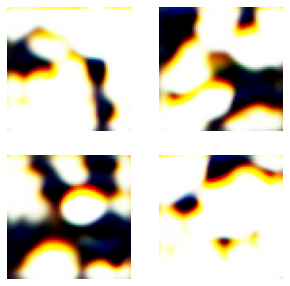

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.7239404
advesarial loss: 0.7516329


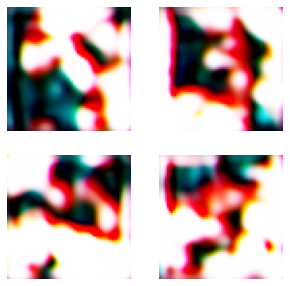

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6764697
advesarial loss: 1.2107329


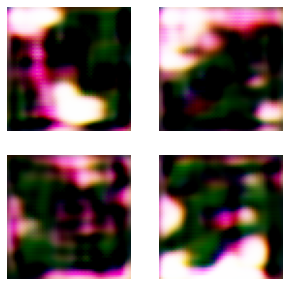

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.591108
advesarial loss: 1.0896113


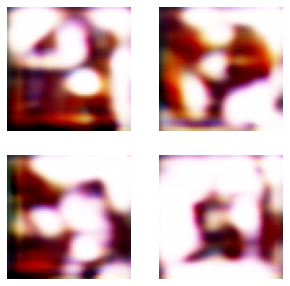

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6318611
advesarial loss: 0.87900805


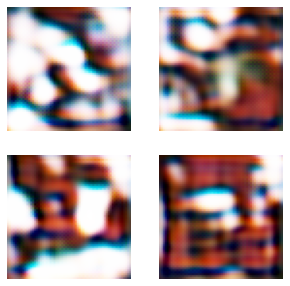

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.68108255
advesarial loss: 2.6721268


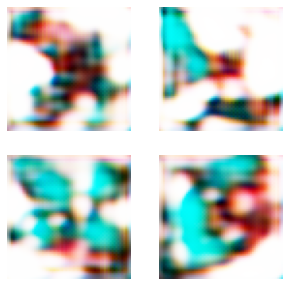

discriminator loss: 0.68108255
advesarial loss: 2.6721268


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.67619663
advesarial loss: 0.82902807


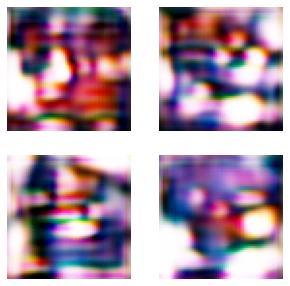

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6398717
advesarial loss: 0.7785613


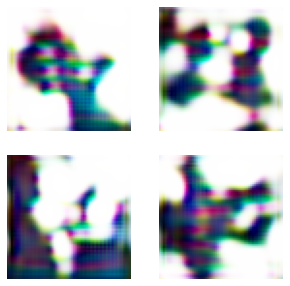

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.7299597
advesarial loss: 0.68398154


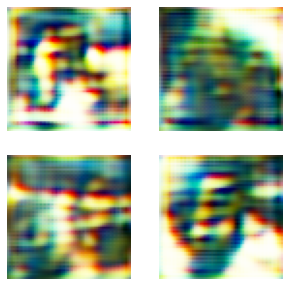

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.7526801
advesarial loss: 1.7889951


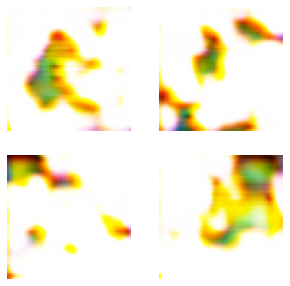

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.7091867
advesarial loss: 0.9701507


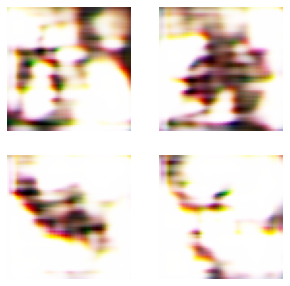

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.7046673
advesarial loss: 0.82651675


In [0]:
Imgno = 0
for step in tqdm_notebook(range(iterations)):
  Imgno += 1
  random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
  generated_images = generator.predict(random_latent_vectors)
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.ones((batch_size,1)), 
                                    np.zeros((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape)
  
  d_loss = discriminator.train_on_batch(combined_images, labels)
  
  random_latent_vectors = np.random.normal(size=(batch_size, 
                                                 latent_dim))
  misleading_targets = np.zeros((batch_size, 1))
  a_loss = gan.train_on_batch(random_latent_vectors, 
                              misleading_targets)
  start += batch_size
  
  if start > len(x_train) - batch_size:
    start = 0
 
  if step % 10 == 0:
    print('discriminator loss:', d_loss)
    print('advesarial loss:', a_loss)
    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(5,5)
    count = 0
    for i in range(2):
      for j in range(2):
        axes[i, j].imshow(resize(generated_images[count], (64,64)))
        axes[i, j].axis('off')
        count += 1
    plt.savefig(f'/content/drive/My Drive/flagsDataset/newGen/image{Imgno}.png')
    plt.show()
    
  if step % 100 == 0:
    # Save the weight. If you want to train for a long time, make sure to save 
    # in your drive. Mount your drive here. Google on how to mount your drive
    # into colab
    gan.save_weights('/content/drive/My Drive/flagsDataset/model.h5')
    
    print('discriminator loss:', d_loss)
    print('advesarial loss:', a_loss)
    

In [0]:
generated_images.shape

In [0]:
real_images.shape